GM CW 1.1

Part 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# sensor data from the provided txt file
earthquake_exercise_data_txt = """1.5575865910322284
2.0316965014178545
2.527159472728958
2.6723924798859993
3.0556883949222513
3.226100565264301
3.413836775759006
2.934969359401483
2.574515504193705
2.6488388964756617
2.9253870488198985
3.1964831294088745
4.565820133697982
7.400903824656596
9.633267837723208
7.016102363491975
4.508193821658606
2.7329525442253204
1.7254938107215634
1.4010698300325652
1.4277427130171043
0.8691896336292224
1.2026529289752554
0.5831154459014418
1.1207179346239071
1.0105518841821948
0.8807933908444603
0.8835180770749729
1.0899061329336812
1.2699960898845595"""

v_observed = np.array([float(x) for x in earthquake_exercise_data_txt.split()])

In [ ]:
# julia script translated into python

# signal each sensor should receive (non-random)
def value(x_spiral, y_spiral, x_sensor, y_sensor):
  d_squared = (x_spiral - x_sensor)**2 + (y_spiral - y_sensor)**2
  return 1 / (d_squared + 0.1)

# explosion detector (using spiral coordinate system)
# define the coordinate system:
S=2000 # number of points on the spiral
rate=25 # angular rate of spiral
sd=0.2 # standard deviation of the sensor Gaussian noise

x=np.zeros(S); y=np.zeros(S)
for s in range(S):
    theta=rate*2*np.pi*s/S;  r=s/S
    x[s]=r*np.cos(theta); y[s]=r*np.sin(theta)

# define the locations of the detection stations on the surface
# Also define what value on each sensor would be generated by an explostion at internal location s
N=30 # number of stations
x_sensor=np.zeros(N); y_sensor=np.zeros(N)
v=np.zeros((S,N))
for sensor in range(N):
    theta_sensor=2*np.pi*sensor/N
    x_sensor[sensor]=np.cos(theta_sensor); y_sensor[sensor]=np.sin(theta_sensor) # x,y coords of each sensor

    # for each point on the spiral, calculate explosion value
    for s in range(S):
        v[s,sensor]=value(x[s],y[s],x_sensor[sensor],y_sensor[sensor]) # explosion value for some value function


In [ ]:
# pdf of v_observed under H1
def p_H1(v_observed, v_true):
  return ((2*np.pi*sd**2)**(-0.5)) * np.exp( (-1/(2*sd**2)) * (v_observed - v_true)**2 )

# pdf of v_observed under H2
def p_H2(v_observed, v_true1, v_true2):
  return ((2*np.pi*sd**2)**(-0.5)) * np.exp( (-1/(2*sd**2)) * (v_observed - (v_true1+v_true2))**2 )

In [ ]:
# v[i,j] gives the true values the sensors would receive

def calculate_conditional_probabilities_H1():
  # for each coordinate on the spiral coordinate system, assign a probability the explosion is there
  v_smth = np.zeros((S,N))
  v_out = np.zeros(S)

  for s in range(S):
    v_smth[s,:] = p_H1(v_observed, v[s,:])

  v_out = np.prod(v_smth, axis=1)
  # normalise
  v_out = v_out / np.sum(v_out)

  return v_out

def calculate_conditional_probabilities_H2():
  # for each coordinate on the spiral coordinate system, assign a probability the explosion is there
  v_smth = np.zeros((S,S,N))
  v_out = np.zeros(S)

  for s in range(S):
    for t in range(S):
      v_smth[s,t,:] = p_H2(v_observed, v[s,:], v[t,:])

  v_out = np.prod(v_smth, axis=2)
  # normalise matrix
  v_out = v_out / np.linalg.norm(v_out)

  # (S,S) matrix where row i and col j correspond to p(s_1, s_2 | v)
  return v_out

probs_H1 = calculate_conditional_probabilities_H1()
probs_H2 = calculate_conditional_probabilities_H2()

In [ ]:
index_H1 = np.argmax(probs_H1)
index_H2 = np.unravel_index(np.argmax(probs_H2), (S,S))

print(index_H1)
print(index_H2)

1797
(1053, 1797)


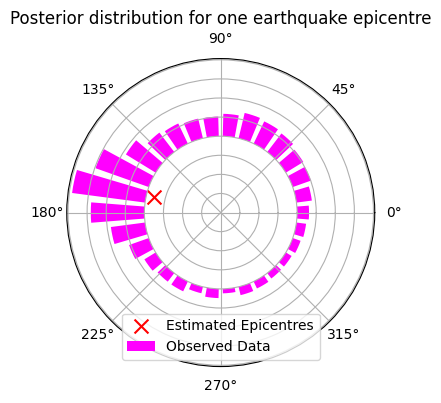

In [ ]:
# plot H1
plt.figure(figsize=(4,4))

# observed value of each sensor
ax = plt.subplot(polar=True)
ax.set_yticklabels([])
ax.set_title("Posterior distribution for one earthquake epicentre")
sensors_theta = np.linspace(0, 2*np.pi, N, endpoint=False)
scale_factor = 10
bars = ax.bar(sensors_theta, v_observed / scale_factor, width=(1.5*np.pi/N), bottom=1,
              color="magenta", label="Observed Data")

# plot epicentres
plt.scatter(rate*2*np.pi*index_H1/S, index_H1/S, marker="x", s=100, color="red", label="Estimated Epicentres")

ax.legend(loc="lower center")
plt.show()

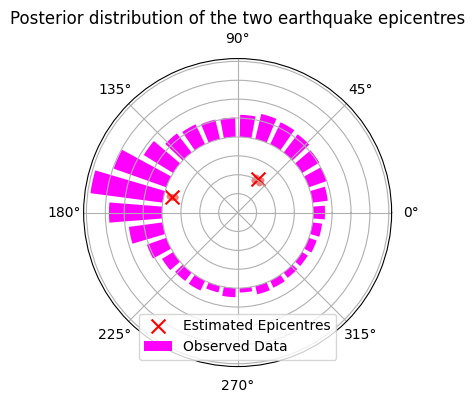

In [ ]:
# plot H2
plt.figure(figsize=(4,4))

# observed value of each sensor
ax = plt.subplot(polar=True)
ax.set_title("Posterior distribution for two earthquake epicentres")
ax.set_yticklabels([])
sensors_theta = np.linspace(0, 2*np.pi, N, endpoint=False)
scale_factor = 10
bars = ax.bar(sensors_theta, v_observed / scale_factor, width=(1.5*np.pi/N), bottom=1,
              color="magenta", label="Observed Data")

# plot posterior distribution
tol = 0.0001
for i in range(S):
  for j in range(S):
    if (i != index_H2[0] or j != index_H2[1]) and probs_H2[i,j] > tol:
      plt.scatter([rate*2*np.pi*i/S, rate*2*np.pi*j/S], [i/S, j/S],
                  color="lightcoral", marker=".")

# plot epicentres
plt.scatter(rate*2*np.pi*index_H2[0]/S, index_H2[0]/S, marker="x", s=100, color="red", label="Estimated Epicentres")
plt.scatter(rate*2*np.pi*index_H2[1]/S, index_H2[1]/S, marker="x", s=100, color="red")

ax.legend(loc="lower center")
plt.show()

Part 2

In [ ]:
def log_likelihood_H1():
  v_smth = p_H1(v_observed, v[index_H1,:])
  v_smth = np.prod(v_smth)
  return np.log(v_smth)

def log_likelihood_H2():
  v_smth = p_H2(v_observed, v[index_H2[0],:], v[index_H2[1],:])
  v_smth = np.prod(v_smth)
  return np.log(v_smth)

ll_H1 = log_likelihood_H1()
ll_H2 = log_likelihood_H2()

print("Log Likelihood H1:", ll_H1)
print("Log Likelihood H2:", ll_H2)

print("Test Statistic:", ll_H2 - ll_H1)

Log Likelihood H1: -738.5736038644479
Log Likelihood H2: 3.5136912715797424
Test Statistic: 742.0872951360277
